In [1]:
import os
import random
import gc
from tqdm import tqdm
import warnings

import math
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd
import pickle

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, BettiCurve, Amplitude

import tensorflow as tf
from tensorflow import keras as tfk
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

DATADIR = 'Data/' 
PROCESSDATA = False


Bad key "text.kerning_factor" on line 4 in
C:\Development\Anaconda\envs\Hambot\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Data

### Save Processed Data

In [2]:
def ProcessData(raw_data_path, processed_data_path='X.parquet'):
    """
    Processes raw training data via Dask to handle memory constraints. Save as parquet file.
    """
    warnings.filterwarnings(action='ignore', category=pd.errors.ParserWarning, module='pandas')
    warnings.filterwarnings(action='ignore', category=pd.errors.ParserWarning, module='dask')

    print('Reading raw data...')
    X = dd.read_csv(raw_data_path, 
                   dtype='float32', 
                   converters={
                        'customer_ID':str, 
                        'S_2':str,
                        'D_63':str,
                        'D_64':str
                  }).rename(columns={'customer_ID' : 'ID', 'S_2' : 'Time'})
    X['Time'] = dd.to_datetime(X['Time'], format='%Y-%m-%d')
    
    # Statement time features
    X['Month'] = X['Time'].apply(lambda t: t.month)
    X['Day'] = X['Time'].apply(lambda t: t.day)

    # Encode Categorical variables
    categoricalVars = ['B_30', 'B_38', 'D_117', 'D_126', 'D_63', 'D_64', 'D_68']
    catRefVal = [ 0.0, 2.0, -1.0, 1.0, 'CO', 'O', 6.0 ]
    X = dd.get_dummies(X.categorize(columns=categoricalVars), columns=categoricalVars).drop(columns=[ f'{col}_{ref}' for col,ref in zip(categoricalVars, catRefVal) ])

    # Execute Dask graph -> pandas MultiIndex & sort
    X = X.compute().set_index(['ID', 'Time']).sort_index(level=[0,1])
    
    # Trim substantial missing columns & clean data
    threshold = 0.7
    missingCols = (X.isna().sum() / len(X)).sort_values(ascending=False)
    missingCols = missingCols[missingCols>=threshold].index
    X = X.drop(columns=missingCols).groupby(level=0).ffill().fillna(0)

    ## Feature Engineering
    meanSpendFeatures = X.loc[:,X.columns.str.startswith('S')].mean(axis=1)
    meanPaymentFeatures = X.loc[:,X.columns.str.startswith('P')].mean(axis=1)
    meanBalanceFeatures = X.loc[:,X.columns.str.startswith('B')].mean(axis=1)
    X['SpendPaymentRatio'] = meanSpendFeatures / meanPaymentFeatures
    X['SpendBalanceRatio'] = meanSpendFeatures / meanBalanceFeatures
    X['PaymentBalanceRatio'] = meanPaymentFeatures / meanBalanceFeatures
    X['MeanRiskFactor'] = X.loc[:,X.columns.str.startswith('R')].mean(axis=1)
    X['MeanDelinquencyFactor'] = X.loc[:,X.columns.str.startswith('D')].mean(axis=1)
    X['RiskBalanceFactor'] = X['MeanRiskFactor'] * meanBalanceFeatures
    
    # Aligned IDs
    IDs = pd.read_csv(DATADIR+'raw/train_labels.csv', usecols=['customer_ID']).sort_values('customer_ID')
    IDs.to_parquet(DATADIR+'IDs.parquet')
    
    print('Data loaded. Saving...')
    
    # Save clean features
    X.to_parquet(processed_data_path)
    print('Completed.')

    return

RAW_DATA_PATH = DATADIR + 'raw/train_data.csv'
PROCESSED_DATA_PATH = DATADIR + 'X.parquet'
if not os.path.exists(PROCESSED_DATA_PATH):
    ProcessData(RAW_DATA_PATH, PROCESSED_DATA_PATH)

### Load Processed Data

In [3]:
# Features
X = dd.read_parquet(PROCESSED_DATA_PATH, index=False).compute().set_index(['ID','Time']).astype('float32')

# Outcomes
IDs = list(pd.read_parquet(DATADIR+'IDs.parquet')['customer_ID'].values)
Y = dd.read_csv(RAW_DATA_PATH, 
                dtype='float32', 
                converters={'customer_ID':str}).compute().rename(columns={'customer_ID' : 'ID', 'target' : 'True'}).set_index('ID').loc[IDs,:]

C:\Development\Anaconda\envs\Hambot\lib\site-packages\pyarrow\compat.py:25: FutureWarning:

pyarrow.compat has been deprecated and will be removed in a future release

C:\Development\Anaconda\envs\Hambot\lib\site-packages\dask\dataframe\io\csv.py:518: ParserWarning:

Both a converter and dtype were specified for column customer_ID - only the converter will be used

C:\Development\Anaconda\envs\Hambot\lib\site-packages\dask\dataframe\io\csv.py:149: ParserWarning:

Both a converter and dtype were specified for column customer_ID - only the converter will be used



### Data Structuring

In [4]:
maxPeriods = X.reset_index().groupby('ID')['Time'].count().max()
X_idx = X.index
X_cols = X.columns
numFeatures = len(X_cols)
print(f'X: {X.shape} -> Y: {Y.shape}')

X: (5531451, 195) -> Y: (458913, 1)


#### Class Imbalance Weights

[0.67470338 1.9309969 ]


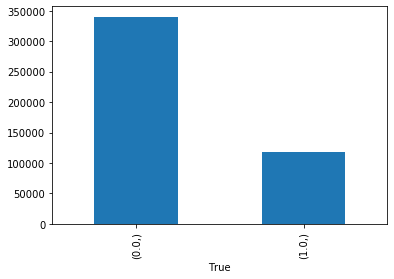

In [5]:
from sklearn.utils.class_weight import compute_class_weight

classWeights = compute_class_weight(class_weight='balanced', classes=[0.,1.], y=Y['True'])

print(classWeights)
Y.value_counts().plot(kind='bar')
plt.show()

#### Aggregate Individual-level Data

In [6]:
# Cross-sectional aggregate individual-level data
Z = X.groupby(level=0).agg(['min','max','mean','std','last']).fillna(0.)
Z.columns = Z.columns.map('_'.join)
Z_cols = list(Z.columns)

#### Structure Panel Data

In [7]:
## Standardization
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X = pd.DataFrame(X_scaler.fit_transform( X.reset_index().loc[:,X_cols].values ))
X.index = X_idx
X.columns = X_cols

## Vectorization
def VectorizeFeatures(X, maxPeriods=13, numFeatures=214):
    """
    Vectorizes MultiIndex Features Panel Data -> 3D Array (ID, timestep, *)
    """
    IDs = X.index.get_level_values(0).unique()
    N = len(IDs)
    
    X_arr = np.zeros( (N, maxPeriods, numFeatures) )
    for n,ID in enumerate(tqdm(IDs)):
        customerDat = X.xs(ID, level=0).values
        
        # Add backfill-padding
        numObs = customerDat.shape[0]
        if numObs < maxPeriods:
            pad = maxPeriods - numObs
            pad = np.repeat( customerDat[[0],:], pad, axis=0 )
            customerDat = np.concatenate([pad, customerDat], axis=0)
            
        X_arr[n,:,:] = customerDat
        
    return np.float32(X_arr)
X = VectorizeFeatures(X, maxPeriods=maxPeriods, numFeatures=numFeatures)
print(f'X: {X.shape}')

100%|████████████████████████████████████████████████████████████████████████| 458913/458913 [01:25<00:00, 5383.24it/s]


X: (458913, 13, 195)


#### Structure Individual-level Data

In [8]:
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints


## Topological feature extraction via persistent homology

# Persistent homology on panel features
homologyDimensions = [0, 1, 2]
totalDim = len(homologyDimensions)
VR = VietorisRipsPersistence(homology_dimensions=homologyDimensions, collapse_edges=True, n_jobs=-1)
persistentHomology = VR.fit_transform( X )

# Number of off-diagonal points of homology
NOP = NumberOfPoints(n_jobs=-1)
numPoints = NOP.fit_transform( persistentHomology )

# Amplitude of homology
AMP = Amplitude(metric='bottleneck', n_jobs=-1)
amplitude = AMP.fit_transform( persistentHomology )

# Entropy of homology
PE = PersistenceEntropy(normalize=True, nan_fill_value=0, n_jobs=-1)
entropy = PE.fit_transform( persistentHomology )

## Full cross-sectional individual-level data

Z = np.nan_to_num(np.concatenate([Z.values, numPoints, amplitude, entropy], axis=-1), nan=0., posinf=0., neginf=0.)

# Standardization
Z_scaler = StandardScaler()
Z = pd.DataFrame(Z_scaler.fit_transform( Z ), index=IDs).fillna(0.)
Z.columns = Z_cols + [f'HomologyPoints_{k}' for k in range(totalDim)] + [f'HomologyAmp_{k}' for k in range(totalDim)] + [f'HomologyEntrop_{k}' for k in range(totalDim)]
numIndivFeatures = len(Z.columns)

del persistentHomology, numPoints, amplitude, entropy
_ = gc.collect()

C:\Development\Anaconda\envs\Hambot\lib\site-packages\numpy\lib\nanfunctions.py:1546: RuntimeWarning:

overflow encountered in multiply



#### Train/Test Split

In [9]:
## Assumption: Credit Default is conditionally independent across customers (no spillage or macroeconomic shocks)
TESTSIZE = 0.2
N = len(IDs)

# Indices of train/test data
idx = [n for n in range(N)]
test_idx = random.sample(idx, int(TESTSIZE*N))
train_idx = list(set(idx) - set(test_idx))

# Customer IDs of train/test data
train_IDs = np.array(IDs)[train_idx]
test_IDs = np.array(IDs)[test_idx]

# Train/test data
X_train = X[train_idx,:,:]
X_test = X[test_idx,:,:]
Z_train = Z.values[train_idx,:]
Z_test = Z.values[test_idx,:]
Y_train = Y.values[train_idx,:]
Y_test = Y.values[test_idx,:]

del X, Y, Z
gc.collect()
print(f'[Train] X: {X_train.shape} Z: {Z_train.shape} -> Y: {Y_train.shape}')
print(f'[Test] X: {X_test.shape} Z: {Z_test.shape} -> Y: {Y_test.shape}')

[Train] X: (367131, 13, 195) Z: (367131, 984) -> Y: (367131, 1)
[Test] X: (91782, 13, 195) Z: (91782, 984) -> Y: (91782, 1)


## Model

In [11]:
import tensorflow as tf
from tensorflow import keras as tfk

## Model Specifications

modelSpecs = {
    'PERSIST_ARCH' : [128, 128],
    'RNN_ARCH' : [64, 32, 64],
    'SIGNAL_ARCH' : [128, 128],
    'DROPOUT' : 0.1,
    'L1L2' : 0.001
}

BATCHSIZE = 10000
EPOCHS = 10000

## Data Generator

class DataGenerator(tfk.utils.Sequence):
    """
    TensorFlow Keras data generator for memory efficiency
    """

    def __init__(self, X, Y, Z, BATCHSIZE):
        data = [X, Y, Z]
        for k in range(len(data)):
            if isinstance(data[k], pd.DataFrame):
                data[k] = data[k].values
        self.X, self.Y, self.Z = data
        self.BATCHSIZE = BATCHSIZE

    def __len__(self):
        return math.ceil(len(self.Y) / self.BATCHSIZE)

    def __getitem__(self, idx):
        X_batch = self.X[(idx * self.BATCHSIZE) : ((idx+1) * self.BATCHSIZE), :, :]
        Y_batch = self.Y[(idx * self.BATCHSIZE) : ((idx+1) * self.BATCHSIZE), :]
        Z_batch = self.Z[(idx * self.BATCHSIZE) : ((idx+1) * self.BATCHSIZE), :]
        return ( [X_batch, Z_batch], [Y_batch] )
trainDataGenerator = DataGenerator(X_train, Y_train, Z_train, BATCHSIZE=BATCHSIZE)
testDataGenerator = DataGenerator(X_test, Y_test, Z_test, BATCHSIZE=BATCHSIZE)

### Neural Network Architecture

In [14]:
class TimeAttention(tfk.layers.Layer):
    """
    Attention layer over time for sequential models.
    """
    def __init__(self, return_sequences=False, name_='Attention'):
        super(TimeAttention, self).__init__()
        self.return_sequences = return_sequences
        self.name_ = name_

    def build(self, input_shape):
        # Input shape: X = (N, T, K)
        kernel_shape = (input_shape[-1], 1)  # Shape: (K, 1)
        bias_shape = (input_shape[1], 1)     # Shape: (T, 1)
        kernelInit = tfk.initializers.RandomNormal(1., 0.1)
        biasInit = tfk.initializers.RandomNormal(0., 1e-4)
        self.W = tf.Variable(
                    kernelInit(shape=kernel_shape),
                    trainable=True,
                    name=self.name+'-W'
        )
        self.b = tf.Variable(
                    biasInit(shape=bias_shape),
                    trainable=True,
                    name=self.name+'-b'
        )

    def call(self, x):
        # Context of time series & time loadings/importance
        context = tf.math.tanh( tf.tensordot(x, self.W, axes=1) + self.b )  # Shape: (N, T, 1)
        beta = tf.math.softmax(context, axis=1)                             # Shape: (N, T, 1)
        
        # Processed time series with attention weights
        output = x*beta
        if self.return_sequences:
            return output
        return tf.math.reduce_sum(output, axis=1)
class SnapshotModelCheckpoint(tfk.callbacks.Callback):
    """
    Keras Callback for Snapshot Ensembling. To be used with cosine annealing.

    Reference: 
     https://github.com/titu1994/Snapshot-Ensembles/blob/master/snapshot.py
     Loshchilov and Hunter (2016), SGDR: Stochastic Gradient Descent with Warm Restarts
    """

    def __init__(self, numEpochs, numSnapshots=10, dirpath='Ensemble/', model_prefix='Model'):
        super(SnapshotModelCheckpoint, self).__init__()
        self.annealCounter = numEpochs // numSnapshots
        self.model_prefix = model_prefix

    def on_epoch_end(self, epoch, logs={}):
        if (epoch != 0) and ( ((epoch + 1) % self.annealCounter) == 0 ):
            filepath = self.dirpath + self.model_prefix + f'-{ ((epoch+1) // self.annealCounter) }.h5'
            self.model.save_weights(filepath, overwrite=True)
            print(f'Saved snapshot at {dirpath}/{self.model_prefix}-{ ((epoch+1) // self.annealCounter) }.h5') 
class SnapshotCallbackBuilder:
    """
    Helper function for creating list of Keras Callbacks for Snapshot Ensembling.
    
    Reference: https://github.com/titu1994/Snapshot-Ensembles/blob/master/snapshot.py
    """

    def __init__(self, numEpochs, numSnapshots=10, init_lr=0.1):
        self.numEpochs = numEpochs
        self.numSnapshots = numSnapshots
        self.init_lr = init_lr

    def get_callbacks(self, dirpath='Ensemble/', model_prefix='Model'):
        # Save ensembled models to this directory
        if not os.path.exists(dirpath):
            os.makedirs(dirpath)

        callbacks = [
            tfk.callbacks.ModelCheckpoint(dirpath + f'{model_prefix}-Best.h5', 
                                          monitor='val_loss',
                                          mode='min',
                                          save_best_only=True, 
                                          save_weights_only=True),
            tfk.callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule),
            SnapshotModelCheckpoint(self.numEpochs, self.numSnapshots, dirpath=dirpath, model_prefix=model_prefix)
        ]

        return callbacks

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.numEpochs // self.numSnapshots))
        cos_inner /= self.numEpochs // self.numSnapshots
        cos_out = np.cos(cos_inner) + 1
        return float(self.init_lr / 2 * cos_out)  
    
def CompileModel(modelSpecs, maxPeriods=13, numFeatures=214, numIndivFeatures=576):
    """
    Compiles the Deep Learning Model.
    
    Args:
        modelSpecs (dict)
          'PERSIST_ARCH' = Architecture of latent persistent representation (through time)
          'RNN_ARCH' = Architecture of recurrent memory cells
          'SIGNAL_ARCH' = Architecture of signal extraction layers
          'DROPOUT' = Dropout on fully connected layers
          'L1L2' = Regularization on fully conntected layers
    """
    
    ## Model Inputs
    x = tfk.Input(shape=(maxPeriods, numFeatures), name='X')
    z = tfk.Input(shape=(numIndivFeatures,), name='Z')
    
    ## Temporal Dynamics via RNN
    f = x
    
    # Attention weights through time
    f = TimeAttention(return_sequences=True, name_='Attention0')(f)
    
    # Latent persistent representation through time
    for k,nodes in enumerate(modelSpecs['PERSIST_ARCH']):
        f = tfk.layers.Dense(nodes,
                             kernel_regularizer=tfk.regularizers.L1L2(modelSpecs['L1L2'],modelSpecs['L1L2']),
                             kernel_initializer=tfk.initializers.HeNormal(),
                             bias_initializer=tfk.initializers.RandomNormal(0.,1e-4),
                             name=f'PersistDense{k}'
                            )(f)
        f = tfk.layers.BatchNormalization()(f)
        f = tfk.layers.PReLU()(f)
        f = tfk.layers.Dropout( modelSpecs['DROPOUT'] )(f)
    
    # Recurrent LSTM layers
    f, *states = tfk.layers.LSTM(modelSpecs['RNN_ARCH'][0],
                            bias_initializer=tfk.initializers.RandomNormal(0., 1e-4),
                            stateful=False,
                            return_sequences=True,
                            return_state=True,
                            dropout=modelSpecs['DROPOUT'],
                            name=f'LSTM0'
                           )(f)
    f = TimeAttention(return_sequences=True, name_='Attention1')(f)
        
    for k,nodes in enumerate(modelSpecs['RNN_ARCH'][1:-1]):
        f = tfk.layers.LSTM(nodes,
                            bias_initializer=tfk.initializers.RandomNormal(0., 1e-4),
                            stateful=False,
                            return_sequences=True,
                            dropout=modelSpecs['DROPOUT'],
                            name=f'LSTM{k+1}'
                           )(f)
        f = TimeAttention(return_sequences=True, name_=f'Attention{k+2}')(f)
        
    f = tfk.layers.LSTM(modelSpecs['RNN_ARCH'][-1],
                            bias_initializer=tfk.initializers.RandomNormal(0., 1e-4),
                            stateful=False,
                            return_sequences=False,
                            dropout=modelSpecs['DROPOUT'],
                            name=f'LSTM{len(modelSpecs["RNN_ARCH"])-1}'
                           )(f, initial_state=states)
    
    ## Cross-sectional Signal Processing
        
    f = tfk.layers.Concatenate(axis=-1)([f, z])
        
    # Signal extraction layers
    for k,nodes in enumerate(modelSpecs['SIGNAL_ARCH']):
        f = tfk.layers.Dense(nodes,
                             kernel_regularizer=tfk.regularizers.L1L2(modelSpecs['L1L2'],modelSpecs['L1L2']),
                             kernel_initializer=tfk.initializers.HeNormal(),
                             bias_initializer=tfk.initializers.RandomNormal(0.,1e-4),
                             name=f'SignalDense{k}'
                            )(f)
        f = tfk.layers.BatchNormalization()(f)
        f = tfk.layers.PReLU()(f)
        if k != (len(modelSpecs['SIGNAL_ARCH']) - 1):
            f = tfk.layers.Dropout( modelSpecs['DROPOUT'] )(f)
        
    # Estimated credit default probability
    y_hat = tfk.layers.Dense(1,
                         activation=tf.math.sigmoid,
                         kernel_initializer=tfk.initializers.HeNormal(),
                         bias_initializer=tfk.initializers.RandomNormal(0.,1e-4),
                         name='Prediction'
                        )(f)
    
    ## Model Compilation & Objective Functions
    
    def CompositeLoss(classWeights, gamma=0.55, delta=2):
        """
        Composite loss for jointly optimizing maximum likelihood and smooth approximation to AUC via 
        gradient-based minimization.

        Hyperparameters are calibrated via Monte Carlo experiments to approximate official metric 
        and maximize correlations:
            `gamma` : 0.55 [Threshold parameter in approxiate AUC for pairwise separation]
            `delta` : 2 [Uncalibrated parameter in approximate AUC - ensures convexity]
        """
        def compute_loss(y_true, y_hat):
            def BinaryCE(y_true, y_hat):
                epsilon = 1e-6
                loss = -( (classWeights[1] * y_true * tf.math.log(y_hat + epsilon)) + (classWeights[0] * (1.0 - y_true) * tf.math.log(1.0 - (y_hat-epsilon))) )
                return tf.reduce_sum(loss, axis=-1)
            def SmoothApproxAUCLoss(y_true, y_hat):
                """
                Smooth and differentiable approximation to negative (unweighted) AUC for minimization.

                Reference: Lian, Yan, et al. Optimizing Classifier Performance via an Approximation to the Wilcoxon-Mann-Whitney Statistic. 2003.
                """
                DTYPE = y_true.dtype

                # Indicators for true positive/negative labels
                i_idx = tf.equal(y_true, 1)
                j_idx = tf.equal(y_true, 0)
                I = tf.math.reduce_sum(tf.cast(i_idx, DTYPE))
                J = tf.math.reduce_sum(tf.cast(j_idx, DTYPE))

                # Estimated probabilities for true positive/negative labels
                p_plus = tf.expand_dims(tf.expand_dims(y_hat[i_idx], axis=-1), axis=-1)  # Shape: (I, 1, 1)
                p_neg = tf.expand_dims(y_hat[j_idx], axis=-1)                            # Shape: (J, 1)

                # Approx AUC per (i,j) pair of estimates
                R_ij = tf.where( 
                        (p_plus - p_neg < gamma), 
                        tf.math.pow(-( p_plus - p_neg - gamma ), delta), 
                        0.
                    )

                # Sample Approx AUC metric
                R = tf.math.reduce_sum( R_ij ) / (I * J)
                return R
            def SmoothApproxDefaultRateLoss(y_true, y_hat):
                """
                Smooth and differentiable approximation to negative default rate loss for minimization.
                Note: Differentiability is ensured by including the magnitude of probability estimates.
                """
                # Sort by estimated probabilities
                sorted_idx = tf.argsort(y_hat[:,0], axis=0, direction='DESCENDING')
                y_true = tf.gather(y_true, sorted_idx, axis=0)
                y_hat = tf.gather(y_hat, sorted_idx, axis=0)

                # Simulate upsampling at ratio of 20:1
                weights = (20. - (19. * y_true))[:,0]
                upsampledN = tf.math.reduce_sum(weights)

                # Cutoff at top 4% of upsampled data
                cutoff = tf.math.reduce_max(tf.where(tf.math.cumsum(weights) <= (0.04 * upsampledN)))

                # Approx Default Rate: Proportion of top 4% captured
                defaultRate = -(tf.math.reduce_sum(y_true[:cutoff,:] * y_hat[:cutoff,:]) / tf.math.reduce_sum(y_true))
                return defaultRate

            # MLE of Y|X ~ Bernoulli(f_DNN(X))
            #logLik = BinaryCE(y_true, y_hat)

            # Smooth Approximation to negative AUC
            AUC = SmoothApproxAUCLoss(y_true, y_hat)
            G = 2*AUC + 1.

            # Smooth Approximation to negative Default Rate
            D = SmoothApproxDefaultRateLoss(y_true, y_hat)

            # Composite Loss
            loss = 0.5 * (G + D)
            return loss
        return compute_loss

    model = tfk.Model(inputs=[x,z], outputs=[y_hat])
    model.compile(
                loss=CompositeLoss(classWeights),
                optimizer=tfk.optimizers.Adam(),
                metrics=[tfk.metrics.BinaryAccuracy(),]
    )
    
    return model

model = CompileModel(modelSpecs, maxPeriods=maxPeriods, numFeatures=numFeatures, numIndivFeatures=numIndivFeatures)
#model.summary()

### Training

In [16]:
## Model Training

logdir = "logs/" + '128x2_64x32x64_64x2_0.1D_0.01L'
callbacks=[
      tfk.callbacks.EarlyStopping(
            patience=50,
            mode='min',
            min_delta=1e-6,
            restore_best_weights=True,
            verbose=1
      ),
      #tfk.callbacks.ReduceLROnPlateau(
      #      factor=0.5, 
      #      patience=20,
      #      mode='min',
      #      min_delta=1e-7,
      #      verbose=1
      #),
     #tfk.callbacks.TensorBoard(log_dir=logdir, write_graph=False, histogram_freq=1)
  ]
numSnapshots = 10
snapshot = SnapshotCallbackBuilder(EPOCHS, numSnapshots, 0.1) 
callbacks = callbacks + snapshot.get_callbacks()
    
lossHistory = model.fit(trainDataGenerator,
                        validation_data=testDataGenerator,
                        epochs=EPOCHS,
                        batch_size=BATCHSIZE,
                        shuffle=False,
                        callbacks=callbacks
                       )
lossHistory = pd.DataFrame(lossHistory.history)

Epoch 1/10000


C:\Development\Anaconda\envs\Hambot\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning:

Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/compute_loss/Reshape_5:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/compute_loss/Reshape_4:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/compute_loss/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.



37/37 [==============================] - 13s 156ms/step - loss: 6.9171 - binary_accuracy: 0.7971 - val_loss: 3.5816 - val_binary_accuracy: 0.8263
Epoch 2/10000
37/37 [==============================] - 5s 131ms/step - loss: 3.1733 - binary_accuracy: 0.8105 - val_loss: 2.8871 - val_binary_accuracy: 0.8797
Epoch 3/10000
37/37 [==============================] - 5s 129ms/step - loss: 2.7918 - binary_accuracy: 0.8236 - val_loss: 2.7224 - val_binary_accuracy: 0.8306
Epoch 4/10000
37/37 [==============================] - 5s 130ms/step - loss: 2.8980 - binary_accuracy: 0.8187 - val_loss: 2.8595 - val_binary_accuracy: 0.8276
Epoch 5/10000
37/37 [==============================] - 5s 127ms/step - loss: 2.7494 - binary_accuracy: 0.8354 - val_loss: 2.8268 - val_binary_accuracy: 0.8893
Epoch 6/10000
37/37 [==============================] - 5s 130ms/step - loss: 2.7718 - binary_accuracy: 0.8335 - val_loss: 2.7752 - val_binary_accuracy: 0.7812
Epoch 7/10000
37/37 [==============================] - 5s 1

KeyboardInterrupt: 

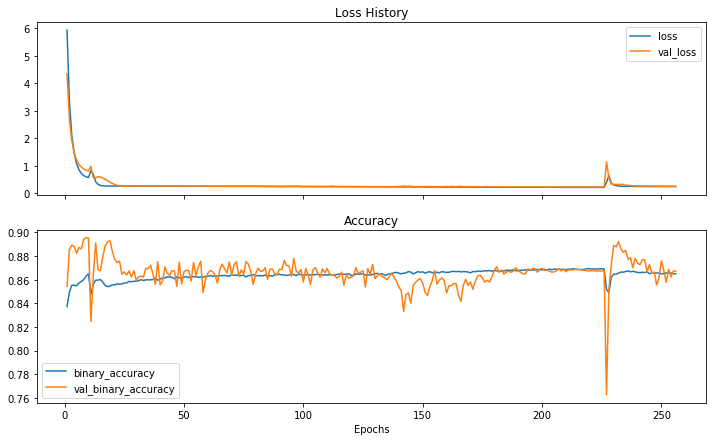

In [62]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(12,7))
lossHistory.loc[:,['loss','val_loss']].iloc[1:,:].plot(ax=ax[0], xlabel='Epochs', title='Loss History')
lossHistory.loc[:,['binary_accuracy', 'val_binary_accuracy']].iloc[1:,:].plot(ax=ax[1], xlabel='Epochs', title='Accuracy')
plt.show()

### Estimation

In [63]:
Y_hat_train = model.predict(trainDataGenerator, verbose=1)
Y_hat_test = model.predict(testDataGenerator, verbose=1)

10/10 [==============================] - 1s 53ms/step


In [64]:
Y_hat_train = pd.DataFrame(Y_hat_train, index=train_IDs)
Y_hat_train.columns = ['Estimate']
Y_hat_test = pd.DataFrame(Y_hat_test, index=test_IDs)
Y_hat_test.columns = ['Estimate']

Y_train = pd.DataFrame(Y_train, index=train_IDs)
Y_train.columns = ['True']
Y_test = pd.DataFrame(Y_test, index=test_IDs)
Y_test.columns = ['True']

### Evaluation

In [65]:
from IPython.display import display, Markdown
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, roc_auc_score

def Evaluate(Y_true, Y_hat, name='TRAIN', loss=None):
    """
    Full evaluation report.
    """
    txt = f'EVALUATION REPORT FOR {name} SET'
    display(Markdown(f'**{txt}**'))
    
    
    # Estimated status: Good Standing (0) or Default (1)
    status = Y_true['True']
    status_hat = Y_hat['Estimate'].apply(lambda p: 1 if p >= 0.5 else 0)
    
    fig,ax = plt.subplots(1,2, figsize=(12,7))
    
    ## Confusion Matrix
    
    cm = confusion_matrix(status, status_hat, normalize='all')
    ax[0].set_title('Confusion Matrix')
    disp = ConfusionMatrixDisplay(cm, display_labels=['Good Standing', 'Default'])
    disp.plot(ax=ax[0])
    
    ## ROC-AUC Curve
    fpr, tpr, _ = roc_curve(status, Y_hat['Estimate'])
    auc = roc_auc_score(status, Y_hat['Estimate'])
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax[1])
    ax[1].set_title('ROC-AUC Curve')
    plt.show()
    
    ## Classification Report
    
    cr = classification_report(status, status_hat, output_dict=True)
    classMetrics = pd.DataFrame({k : cr[k] for k in ['0.0','1.0']})
    classMetrics.columns = ['Good Standing', 'Default']
    display(classMetrics)
    
    ## Full Metrics
    
    # Official Evaluation Metric
    def ComputeEvaluationMetric(Y_true, Y_hat):
        """
        Computes the official evaluation metric:
            M = 0.5 * (G + D)
        where G is normalized Gini coefficient, D is default rate. Negative labels are weighted by 20
        due to data downsampling.
        """

        def WeightedGiniCoefficient(df):

            # Weighted negative labels due to downsampling
            weights = df['True'].apply( lambda x: 20 if x==0 else 1 )

            # Random assignment (Gini=0)
            random = (weights / weights.sum()).cumsum()

            # Total & Cumulative number of credit defaults
            totalDefaults = (df['True'] * weights).sum()
            cumDefaults = (df['True'] * weights).cumsum()

            # Lorenz curve 
            lorenz = cumDefaults / totalDefaults

            # Gini coefficient
            gini = ( (lorenz - random) * weights ).sum()

            return gini

        def DefaultRate(df):

            # Weighted negative labels due to downsampling
            weights = df['True'].apply( lambda x: 20 if x==0 else 1 )

            # Cumulative weights
            cumWeights = weights.cumsum()

            # Cumulative cut-off point for highest 4% of estimates
            cutoff = int( 0.04 * weights.sum() )
            df_cutoff = df.loc[ cumWeights <= cutoff, : ]

            # Default rate
            totalDefaults = (df['True'] == 1).sum()
            estCutoffDefaults = (df_cutoff['True'] == 1).sum()
            defaultRate = estCutoffDefaults / totalDefaults

            return defaultRate

        df = pd.concat([Y_true, Y_hat], axis=1)
        df.columns = ['True', 'Estimate']
        df = df.sort_values('Estimate', ascending=False)

        ## Compute normalized Gini coefficient: G

        giniCoeff = WeightedGiniCoefficient( df )

        df2 = pd.concat([Y_true, Y_true], axis=1)
        df2.columns = ['True', 'Estimate']
        df2 = df2.sort_values('Estimate', ascending=False)
        giniNormFactor = WeightedGiniCoefficient( df2 )

        G = giniCoeff / giniNormFactor

        ## Compute Default Rate

        D = DefaultRate( df )

        ## Evaluation Metric

        metric = 0.5 * (G + D)

        return metric
    evalMetric = ComputeEvaluationMetric(Y_true, Y_hat)
    
    allMetrics = {
        'Official Metric' : evalMetric,
        'AUC' : auc,
        'Accuracy' : cr['accuracy'],
        'Loss' : loss
    }
    allMetrics = pd.DataFrame(allMetrics, index=['.']).T
    display(allMetrics)
    
    return

**EVALUATION REPORT FOR TRAIN SET**

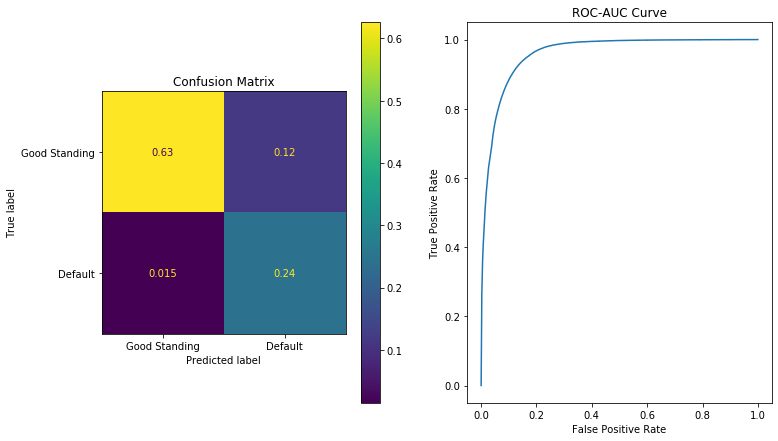

,Good Standing,Default
precision,0.976755,0.679305
recall,0.844526,0.942483
f1-score,0.905840,0.789540
support,272064.000000,95067.000000


,.
Official Metric,0.783373
AUC,0.960035
Accuracy,0.869891
Loss,0.222859


In [66]:
loss = model.evaluate(trainDataGenerator, verbose=0, return_dict=True)['loss']
Evaluate(Y_train, Y_hat_train, name='TRAIN', loss=loss)

**EVALUATION REPORT FOR TEST SET**

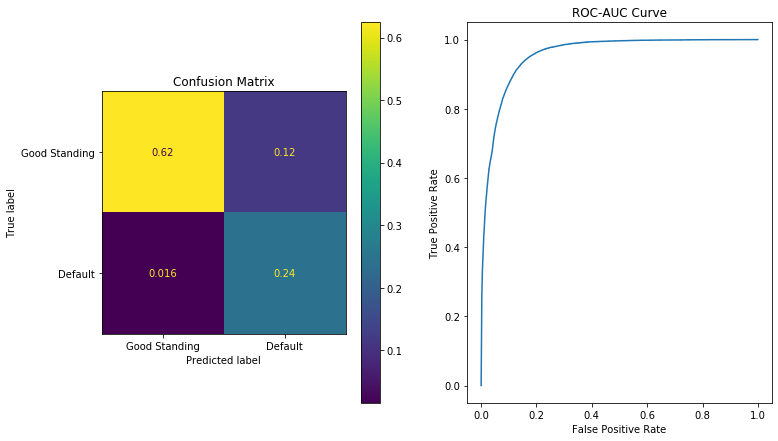

,Good Standing,Default
precision,0.975437,0.675607
recall,0.842460,0.939270
f1-score,0.904085,0.785914
support,68021.000000,23761.000000


,.
Official Metric,0.772698
AUC,0.956916
Accuracy,0.867523
Loss,0.233409


In [67]:
loss = model.evaluate(testDataGenerator, verbose=0, return_dict=True)['loss']
Evaluate(Y_test, Y_hat_test, name='TEST', loss=loss)

### Approximate Loss Monte Carlo Experiments

In [38]:
def ComputeLossBreakdown(Y_true, Y_hat, BATCHSIZE=2500):
    gamma = 0.45
    delta=2
    rho=0.57
    def SmoothApproxAUCLoss(y_true, y_hat):
        """
        Smooth and differentiable approximation to negative (unweighted) AUC for minimization.

        Reference: Lian, Yan, et al. Optimizing Classifier Performance via an Approximation to the Wilcoxon-Mann-Whitney Statistic. 2003.
        """
        DTYPE = y_true.dtype

        # Indicators for true positive/negative labels
        i_idx = tf.equal(y_true, 1)
        j_idx = tf.equal(y_true, 0)
        I = tf.math.reduce_sum(tf.cast(i_idx, DTYPE))
        J = tf.math.reduce_sum(tf.cast(j_idx, DTYPE))

        # Estimated probabilities for true positive/negative labels
        p_plus = tf.expand_dims(tf.expand_dims(y_hat[i_idx], axis=-1), axis=-1)  # Shape: (I, 1, 1)
        p_neg = tf.expand_dims(y_hat[j_idx], axis=-1)                            # Shape: (J, 1)

        # Approx AUC per (i,j) pair of estimates
        R_ij = tf.where( 
                (p_plus - p_neg < gamma), 
                tf.math.pow(-( p_plus - p_neg - gamma ), delta), 
                0.
            )

        # Sample Approx AUC metric
        R = tf.math.reduce_sum( R_ij ) / (I * J)
        return R
    def SmoothApproxDefaultRateLoss(y_true, y_hat):
        """
        Smooth and differentiable approximation to negative default rate loss for minimization.
        Note: Differentiability is ensured by including the magnitude of probability estimates.
        """
        # Sort by estimated probabilities
        sorted_idx = tf.argsort(y_hat[:,0], axis=0, direction='DESCENDING')
        y_true = tf.gather(y_true, sorted_idx, axis=0)
        y_hat = tf.gather(y_hat, sorted_idx, axis=0)

        # Simulate upsampling at ratio of 20:1
        weights = (20. - (19. * y_true))[:,0]
        upsampledN = tf.math.reduce_sum(weights)

        # Cutoff at top 4% of upsampled data
        cutoff = tf.math.reduce_max(tf.where(tf.math.cumsum(weights) <= (0.04 * upsampledN)))

        # Approx Default Rate: Proportion of top 4% captured
        defaultRate = -(tf.math.reduce_sum(y_true[:cutoff,:] * y_hat[:cutoff,:]) / tf.math.reduce_sum(y_true))
        return defaultRate
    N = Y_true.shape[0]
    Y_true = tf.constant(Y_true, dtype=tf.float32)
    Y_hat = tf.constant(Y_hat, dtype=tf.float32)
    G_loss = 0.
    D_loss = 0.
    for k in range(int(N/BATCHSIZE)+1):
        batch_y = Y_true[(k*BATCHSIZE):((k+1)*BATCHSIZE),:]
        batch_y_hat = Y_hat[(k*BATCHSIZE):((k+1)*BATCHSIZE),:]
        batch_auc = SmoothApproxAUCLoss(batch_y, batch_y_hat).numpy()
        batch_d = SmoothApproxDefaultRateLoss(batch_y, batch_y_hat).numpy()
        batch_G = (2*batch_auc) + 1
        G_loss = G_loss + ((batch_G - G_loss)/(k+1))
        D_loss = D_loss + ((batch_d - D_loss)/(k+1))
    return (G_loss, D_loss)
ComputeLossBreakdown(Y_train, Y_hat_train)

In [40]:
def amex_metric_np(target, preds):
    """
    Unofficial numpy version of competition metric.
    
    Source: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
    """
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)

    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)

    g = gini / gini_max
    return 0.5 * (g + d)

def CompositeLoss(classWeights, gamma=0.55, delta=2):
    """
    Composite loss for jointly optimizing maximum likelihood and smooth approximation to AUC via 
    gradient-based minimization.

    Hyperparameters are calibrated via Monte Carlo experiments to approximate official metric 
    and maximize correlations:
        `gamma` : 0.55 [Threshold parameter in approxiate AUC for pairwise separation]
        `delta` : 2 [Uncalibrated parameter in approximate AUC - ensures convexity]
    """
    def compute_loss(y_true, y_hat):
        def BinaryCE(y_true, y_hat):
            epsilon = 1e-6
            loss = -( (classWeights[1] * y_true * tf.math.log(y_hat + epsilon)) + (classWeights[0] * (1.0 - y_true) * tf.math.log(1.0 - (y_hat-epsilon))) )
            return tf.reduce_sum(loss, axis=-1)
        def SmoothApproxAUCLoss(y_true, y_hat):
            """
            Smooth and differentiable approximation to negative (unweighted) AUC for minimization.

            Reference: Lian, Yan, et al. Optimizing Classifier Performance via an Approximation to the Wilcoxon-Mann-Whitney Statistic. 2003.
            """
            DTYPE = y_true.dtype

            # Indicators for true positive/negative labels
            i_idx = tf.equal(y_true, 1)
            j_idx = tf.equal(y_true, 0)
            I = tf.math.reduce_sum(tf.cast(i_idx, DTYPE))
            J = tf.math.reduce_sum(tf.cast(j_idx, DTYPE))

            # Estimated probabilities for true positive/negative labels
            p_plus = tf.expand_dims(tf.expand_dims(y_hat[i_idx], axis=-1), axis=-1)  # Shape: (I, 1, 1)
            p_neg = tf.expand_dims(y_hat[j_idx], axis=-1)                            # Shape: (J, 1)

            # Approx AUC per (i,j) pair of estimates
            R_ij = tf.where( 
                    (p_plus - p_neg < gamma), 
                    tf.math.pow(-( p_plus - p_neg - gamma ), delta), 
                    0.
                )

            # Sample Approx AUC metric
            R = tf.math.reduce_sum( R_ij ) / (I * J)
            return R
        def SmoothApproxDefaultRateLoss(y_true, y_hat):
            """
            Smooth and differentiable approximation to negative default rate loss for minimization.
            Note: Differentiability is ensured by including the magnitude of probability estimates.
            """
            # Sort by estimated probabilities
            sorted_idx = tf.argsort(y_hat[:,0], axis=0, direction='DESCENDING')
            y_true = tf.gather(y_true, sorted_idx, axis=0)
            y_hat = tf.gather(y_hat, sorted_idx, axis=0)

            # Simulate upsampling at ratio of 20:1
            weights = (20. - (19. * y_true))[:,0]
            upsampledN = tf.math.reduce_sum(weights)

            # Cutoff at top 4% of upsampled data
            cutoff = tf.math.reduce_max(tf.where(tf.math.cumsum(weights) <= (0.04 * upsampledN)))

            # Approx Default Rate: Proportion of top 4% captured
            defaultRate = -(tf.math.reduce_sum(y_true[:cutoff,:] * y_hat[:cutoff,:]) / tf.math.reduce_sum(y_true))
            return defaultRate

        # MLE of Y|X ~ Bernoulli(f_DNN(X))
        #logLik = BinaryCE(y_true, y_hat)

        # Smooth Approximation to negative AUC
        AUC = SmoothApproxAUCLoss(y_true, y_hat)
        G = 2*AUC + 1.

        # Smooth Approximation to negative Default Rate
        D = SmoothApproxDefaultRateLoss(y_true, y_hat)

        # Composite Loss
        loss = 0.5 * (G + D)
        return loss
    return compute_loss
    
def MonteCarloLossAnalysis(Y_true, Y_hat, official_loss, surrogate_loss, R=100, numSamples=5000):
    """
    Analysis of official loss metric vs surrogate loss via Monte Carlo experiments.
    """
    idx = [n for n in range(len(Y_true))]
    Y_true_np, Y_hat_np = np.ravel(Y_true.values), np.ravel(Y_hat.values)
    Y_true_ts, Y_hat_ts = tf.constant(Y_true, dtype=tf.float32), tf.constant(Y_hat, tf.float32)
    surrogate_loss = tf.function(surrogate_loss)
    
    ## Monte Carlo experiments
    results = []
    for r in tqdm(range(R)):
        
        # Random sample
        sample_idx = random.sample(idx, numSamples)
        Y_true_np_sample, Y_hat_np_sample = Y_true_np[sample_idx], Y_hat_np[sample_idx]
        Y_true_ts_sample, Y_hat_ts_sample = tf.gather(Y_true_ts, sample_idx, axis=0), tf.gather(Y_hat_ts, sample_idx, axis=0)
        
        # Competition metric
        official_loss_val = official_loss(Y_true_np_sample, Y_hat_np_sample)
        
        # Surrogate metric
        surrogate_loss_val = surrogate_loss(Y_true_ts_sample, Y_hat_ts_sample).numpy()
        
        results.append( (official_loss_val, surrogate_loss_val) )
    results = pd.DataFrame(results)
    results.columns = ['Official', 'Surrogate']
    return results

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.43it/s]


,Official,Surrogate
0,0.800319,0.309624
1,0.797969,0.311522
2,0.804405,0.307133
3,0.779102,0.326293
4,0.802369,0.307993


Correlations:


,Official,Surrogate
Official,1.000000,-0.998487
Surrogate,-0.998487,1.000000


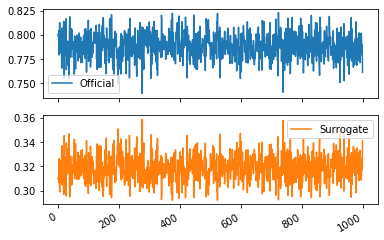

In [41]:
# Monte Carlo analysis of true vs surrogate loss correlations
surrogate_loss = CompositeLoss(classWeights)
results = MonteCarloLossAnalysis(pd.concat([Y_train, Y_test],axis=0), pd.concat([Y_hat_train, Y_hat_test],axis=0), amex_metric_np, surrogate_loss, R=1000)
display(results.head())
print('Correlations:')
display(results.corr())
results.plot(subplots=True)
plt.show()

In [46]:
# Monte Carlo calibration of loss parameters
results = []
Y = pd.concat([Y_train, Y_test],axis=0)
Y_hat = pd.concat([Y_hat_train, Y_hat_test], axis=0)
for k in range(100):
    #rho = k/100
    gamma = k/100
    surrogate_loss = CompositeLoss(classWeights, rho=0.5, gamma=gamma)
    res = MonteCarloLossAnalysis(Y, Y_hat, amex_metric_np, surrogate_loss, R=500)
    means = list(res.mean(axis=0).values)
    corr = res.corr().iloc[0,1]
    val = means + [corr]
    results.append( val )
results = pd.DataFrame(results)
results.columns = ['ExpOfficial', 'ExpSurrogate', 'Corr']
results.index = [k for k in range(100)]

del Y, Y_hat
_ = gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 86.49it/s]


### Save

In [ ]:
if SAVE_AND_SUBMIT:
    SUBMISSIONDIR = 'Submission/'
    
    # Save DNN model
    model.save(SUBMISSIONDIR+'Model')
    
    # Data structure metadata
    dataSpecs = {
        'maxPeriods' : maxPeriods,
        'X_cols' : X_cols,
        'Z_cols' : Z_cols,
        'numFeatures' : numFeatures,
        'numIndivFeatures' : numIndivFeatures,
        'classWeights' : classWeights
    }
    
    # Save preprocessing models
    preprocessPipe = {
        'X_scaler' : X_scaler,
        'Z_scaler' : Z_scaler,
        'VR' : VR,
        'NOP' : NOP,
        'AMP' : AMP,
        'PE' : PE,
        'dataSpecs' : dataSpecs
    }
    with open(SUBMISSIONDIR+'preprocessPipe','wb') as file:
        pickle.dump(preprocessPipe, file)